# Dimensionality reduction using Sentinel-2 (PCA)

Authors:

* Jeroen Wannijn

Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import openeo
import openeo.processes as eop
from eo_processing.utils.helper import getUDFpath
import rasterio
from pathlib import Path
import xarray as xr

# openeo version
openeo.client_version()

'0.42.1'

Creates a output directory if it doesn't exist.

In [2]:
base_path = Path("results")
if not base_path.is_dir():
    base_path.mkdir()

# Introduction
In this notebook, we perform dimensionality reduction on a full data cube of preprocessed Sentinel-2 satellite data. This data can quickly have many dimensions, consisting of many spectral bands, derived indexes and possibly other features, leading to very high-dimensional and heavy datasets. Working directly with such high-dimensional data presents several challenges:


1. Computational Efficiency:
Lower-dimensional data requires less storage and speeds up downstream tasks like classification, clustering, or further processing.

2. Improved Visualization and Interpretation:
By reducing dimensionality, we can visualize complex datasets in 2D or 3D plots, making it easier to understand underlying structures, patterns, or anomalies.

3. Curse of Dimensionality:
As the number of features grows, the data becomes sparse in the feature space, making it harder to find meaningful patterns or clusters. Many machine learning algorithms also suffer performance drops or overfitting in very high dimensions.

## Authentication

We first need to connect to an openEO provider. Most providers require you to register an account, and provide you with a basic amount of processing credits. 
In this notebook we will use the Copernicus Data Space Ecosystem as openEO provider.

All the known openEO providers and their services:
https://hub.openeo.org/ 

More info on authentication:
https://open-eo.github.io/openeo-python-client/auth.html

Run the `authenticate_oidc()` method again in case you can no longer connect. The token expires after a certain time.

In [3]:
backend_url = "openeo.dataspace.copernicus.eu/"

eoconn = openeo.connect(backend_url)
eoconn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [4]:
models_url = "https://s3.waw3-1.cloudferro.com/swift/v1/ecdc-waw3-1-ekqouvq3otv8hmw0njzuvo0g4dy0ys8r985n7dggjis3erkpn5o/tests/JeroenW/DimReduction/onnx_reduction_models.zip"
dependencies_url = (
    "https://s3.waw3-1.cloudferro.com/swift/v1/project_dependencies/onnx_dependencies_1.16.3.zip"
    )
job_options = {
    'driver-memory': '1G',
    'driver-memoryOverhead': '256m',
    'executor-memory': '2G',
    'executor-memoryOverhead': '512m',
    'python-memory': '2G',
    'max-executors': 20,
    "executor-cores": 1,
    "logging-threshold": "info",
    'udf-dependency-archives': [
        f"{models_url}#onnx_models",
        f"{dependencies_url}#onnx_deps"
        ],
}

## Jobs whithin the notebook

This notebook will run two jobs:
- One that select the significant raw bands from the dimensionality reduction model
- One that executes the dimensionality reduction model

One model is applied, from scikit-learn, PCA. It is pre-trained with the same data we use in this notebook, to reduce all bands to 3 components.

It is recommended to zip your dependencies for scikit-learn, joblib & onnx since they differ vastly over the versions.

More info on scikit-learn PCA analysis:
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

## Load collection

We start off by loading in a collection. In this case, we are loading in Sentinel-2 L2A. More information on the collections available can be displayed with `eoconn.list_collections()`.
Use `eoconn.describe_collection("SENTINEL2_L2A")` for example to get the description of a specific collection.

More information on finding and loading data: 
https://open-eo.github.io/openeo-python-client/data_access.html

*Select spatial & temporal extent*

In [5]:
BBOX = {"east": 4878500, "south": 2897000, "west": 4877000, "north": 2898500, 'crs': 'EPSG:3035'} # 1.5x1.5km bbox in Germany
DATE_START = "2021-01-01"
DATE_END = "2022-01-01"

*Select usable observations*:

For this exercise we use the derivatives of the 13 Sentinel-2 bands + NDVI by applying a spatial reduction
- mean 
- median
- max
- min
- q5
- q25
- q75
- q95

This leads to 112 (14x8) dimension to reduce in a dimensionality reduction model.

NDVI is added to indicate that either the source bands, B04 and B08 OR the NDVI will be used to determine significant bands by PCA loadings. It indicates that adding duplicate information has no effect in Dimensionality Reduction.


Load collection

In [6]:
data_cube = eoconn.load_collection(
    "SENTINEL2_L2A",  # or your collection id
    spatial_extent=BBOX,
    temporal_extent=[DATE_START, DATE_END],
    bands=['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12'],
    max_cloud_cover=10
)

Mask cloud data

In [7]:
scl = eoconn.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=[DATE_START, DATE_END],
    spatial_extent=BBOX,
    bands=["SCL"],
    max_cloud_cover=10,
)

cloud_mask = scl.process(
    "to_scl_dilation_mask",
    data=scl,
    kernel1_size=17, kernel2_size=77,
    mask1_values=[2, 4, 5, 6, 7],
    mask2_values=[3, 8, 9, 10, 11],
    erosion_kernel_size=3)

data_cube_masked = data_cube.mask(cloud_mask)

Calculate NDVI

In [8]:
data_cube_masked = data_cube_masked.ndvi(red="B04", nir="B08", target_band='NDVI')

Temporally reduce data cube with different statistics

In [9]:
# Get original band labels
band_labels = data_cube_masked.metadata.band_names

# Temporal reduce and prefix new band names
def combined_reducer(t_array):
    """
    Combined EO processes to reduce temporal resolution of an array
    """
    # Define every eo process
    mean = eop.mean(t_array)
    median = eop.median(t_array)
    min = eop.min(t_array)
    max = eop.max(t_array)
    q05 = eop.quantiles(t_array, probabilities=[0.05])
    q25 = eop.quantiles(t_array, probabilities=[0.25])
    q75 = eop.quantiles(t_array, probabilities=[0.75])
    q95 = eop.quantiles(t_array, probabilities=[0.95])
    
    # Stack eo processes into array
    return eop.array_create([mean, median, min, max, q05, q25, q75, q95])

# Now rename bands accordingly:
target_bands = []
for b in band_labels:
    target_bands.extend([
        f"{b}_mean", f"{b}_median", f"{b}_min", f"{b}_max",
        f"{b}_q05", f"{b}_q25", f"{b}_q75", f"{b}_q95"
    ])

# Temporally reduce cube with combined reducer and rename bands accordingly
sentinel_master_cube = data_cube_masked.apply_dimension(
    process=combined_reducer,
    dimension="t",
    target_dimension="bands"
).rename_labels("bands", target=target_bands)

Download to view offline

In [ ]:
job = sentinel_master_cube.create_job(
    title="building_S2_stat_cube", out_format="NetCDF", job_options=job_options)
job.start_and_wait()
job.download_result(base_path / "master_cube.nc")

## Visualise RGB to get a view of the area
Download RGB data from Sentinel-2 collection (mean value over spatial extent) to view

In [10]:
mean_bands = [b for b in sentinel_master_cube.metadata.band_names if b.endswith('_mean')]

sentinel_mean_cube = sentinel_master_cube.filter_bands(mean_bands)

sentinel_mean_cube.download(base_path / "mean_bands_cube.tiff")

Visualize RGB data

Pixel Size: 10.0 x 10.0 units


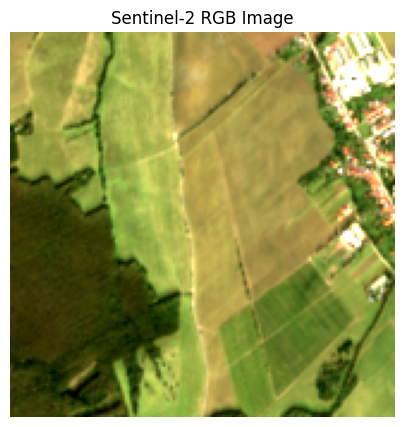

In [11]:
with rasterio.open(base_path / "mean_bands_cube.tiff") as src:
    pixel_size_x = src.transform.a
    pixel_size_y = -src.transform.e
    print(f"Pixel Size: {pixel_size_x} x {pixel_size_y} units")

    r = src.read(4)  # Band 3
    g = src.read(3)  # Band 2
    b = src.read(2)  # Band 1

rgb = np.stack([r, g, b], axis=0)
rgb_img = np.transpose(rgb, (1, 2, 0))

# Normalize using percentiles
def normalize_percentile(img, lower=2, upper=98):
    p_low, p_high = np.percentile(img, (lower, upper))
    img_clipped = np.clip(img, p_low, p_high)
    return (img_clipped - p_low) / (p_high - p_low)

rgb_norm = normalize_percentile(rgb_img)

plt.figure(figsize=(5, 5))
plt.imshow(rgb_norm)
plt.title("Sentinel-2 RGB Image")
plt.axis("off")
plt.show()

## PCA model execution

### Exploration of the data and the model

_PCA characteristics_:
- **Type**: Linear
- **Objective**: Find directions (principal components) that capture the **maximum variance** in the data.
- **Method**: Eigen-decomposition of the covariance matrix.
- **Captures**: **Global structure** in the data.
- **Output**: Linear combinations of original features.
- **Interpretability**: High (components are based on feature contributions).
- **Best for**: Linearly structured data, noise reduction, feature compression, preprocessing for regression or classification.


When performing __PCA__, one of the key outputs is the __Explained Variance Ratio__. This metric tells us how much of the total variance in the original data is captured by each principal component. In other words, it helps us understand:

- How many components are needed to retain most of the information (variance) in the data.

- Which components are most informative, allowing us to reduce dimensionality effectively without losing essential structure.

- Whether dimensionality reduction introduces significant information loss.

This makes the explained variance ratio a crucial diagnostic tool in PCA-based workflows, especially when deciding how many components to retain for visualization or modeling.
Below you can find some model visualizations.

##### Explained Variance Ratio

This visualization helps understand how many principal components are needed to capture most of the variance in the data.    
If the first few bars are tall and the rest are small, it means those components explain most of the variance, and dimensionality reduction can be effective.

![ExplainedVarianceRatio.png](ExplainedVarianceRatio.png)

##### Cumulative Explained Variance

This plot helps you decide how many principal components to keep in your analysis by showing the cumulative amount of variance explained.   
For example, if the curve reaches 90% explained variance at the 4th component, you might choose to keep only the first 4 components for dimensionality reduction, but this is now already reached with 3 components.


![CumulativeExplainedVariance.png](CumulativeExplainedVariance.png)


##### Band Significance curve

 This code helps identify which original spectral bands (features) are most influential in the PCA model by examining the loadings.    
It filters out bands with insignificant contributions and visually ranks bands by their maximum contribution to any principal component.    
This can guide to feature extraction, interpretation, or further analysis by focusing on the most important spectral bands.
 
Only bands with a loading of at least 0.01 are shown. You can see here while NDVI doesn't reach this threshold, that its soucres bands B04 & B08 reach very high loadings.

![BandSignificanceCurve.png](BandSignificanceCurve.png)


##### Significant Band Loadings Heatmap

This heatmap visually summarizes which spectral bands contribute strongly to which principal components and whether the contribution is positive or negative.   
By filtering for significant bands, the plot focuses on the most meaningful relationships (weight > 0.20 for at least one of the components) in the PCA,    
helping you interpret how each component is formed by combinations of original bands.

![AbsoluteSignificantBandLoadingsHeatmap.png](AbsoluteSignificantBandLoadingsHeatmap.png)




### UDF execution
#### UDF: select significant bands by pca loadings

Based on the previous curves we decide to only keep 18 bands (weight > 0.20 on the heatmap). The underlying UDF selects those features based on our PCA model.   
In case you want to keep bands based on the loading, you can also give a threshold betweeen 0 and 1 of how big the loading needs to be.

e.g.*context={"threshold": 0.20}*

In [12]:
siginificant_band_extraction_udf_obj = openeo.UDF.from_file(getUDFpath("udf_select_significant_bands_by_pca_loadings.py"),
                                   context={"top_k": 18, "model_id": "dim_reduction_pca"})
significant_bands_cube = sentinel_master_cube.apply(
    process=siginificant_band_extraction_udf_obj,
)

In [13]:
extraction_job = significant_bands_cube.create_job(
    title="significant_band_extraction_job", out_format="NetCDF", job_options=job_options
)
extraction_job.start_and_wait()
extraction_job.download_result("results/significant_bands.nc")

0:00:00 Job 'j-25082513411545d1af8ed2985db3ea8d': send 'start'
0:00:14 Job 'j-25082513411545d1af8ed2985db3ea8d': created (progress 0%)
0:00:19 Job 'j-25082513411545d1af8ed2985db3ea8d': created (progress 0%)
0:00:25 Job 'j-25082513411545d1af8ed2985db3ea8d': created (progress 0%)
0:00:33 Job 'j-25082513411545d1af8ed2985db3ea8d': created (progress 0%)
0:00:43 Job 'j-25082513411545d1af8ed2985db3ea8d': created (progress 0%)
0:00:56 Job 'j-25082513411545d1af8ed2985db3ea8d': running (progress N/A)
0:01:11 Job 'j-25082513411545d1af8ed2985db3ea8d': running (progress N/A)
0:01:30 Job 'j-25082513411545d1af8ed2985db3ea8d': running (progress N/A)
0:01:54 Job 'j-25082513411545d1af8ed2985db3ea8d': running (progress N/A)
0:02:25 Job 'j-25082513411545d1af8ed2985db3ea8d': running (progress N/A)
0:03:02 Job 'j-25082513411545d1af8ed2985db3ea8d': running (progress N/A)
0:03:49 Job 'j-25082513411545d1af8ed2985db3ea8d': running (progress N/A)
0:04:47 Job 'j-25082513411545d1af8ed2985db3ea8d': running (progres

WindowsPath('results/significant_bands.nc')

Check how many of the bands are reduced and left

In [14]:
# Open the NetCDF file
ds = xr.open_dataset("results/significant_bands.nc")

# Extract band variables, excluding 'crs'
bands = [var for var in ds.data_vars if var != "crs"]

# Print total count
print(f"{len(bands)} bands left:\n")

# Print bands in a numbered list
for i, band in enumerate(bands, start=1):
    print(f"{i}. {band}")

18 bands left:

1. B8A_max
2. B07_max
3. B08_max
4. B8A_q95
5. B07_q95
6. B08_q95
7. B09_max
8. B8A_median
9. B09_median
10. B08_median
11. B08_q75
12. B09_q95
13. B8A_q75
14. B11_max
15. B06_max
16. B09_q75
17. B11_q95
18. B07_q75


#### UDF: apply PCA dimensionality reduction

Apply the Dimensionality Reduction UDF with PCA within a neighbourhood of 512x512 pixels.

In [ ]:
pca_udf_obj = openeo.UDF.from_file(getUDFpath("udf_apply_dim_reduction.py"),
                                   context={"model_id": "dim_reduction_pca"}
                                   )
components = sentinel_master_cube.apply_neighborhood(
    process=pca_udf_obj,
    size=[
        {"dimension": "x", "value": 384, "unit": "px"},
        {"dimension": "y", "value": 384, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 64, "unit": "px"},
        {"dimension": "y", "value": 64, "unit": "px"},
    ],
)
pca_job = components.create_job(
    title="apply_pca_job", out_format="NetCDF", job_options=job_options
)
pca_job.start_and_wait()
pca_job.download_result("results/results_pca.nc")

0:00:00 Job 'j-25082513500742a08dcbf5e6773af42a': send 'start'
0:00:13 Job 'j-25082513500742a08dcbf5e6773af42a': created (progress 0%)
0:00:18 Job 'j-25082513500742a08dcbf5e6773af42a': created (progress 0%)
0:00:25 Job 'j-25082513500742a08dcbf5e6773af42a': created (progress 0%)
0:00:33 Job 'j-25082513500742a08dcbf5e6773af42a': created (progress 0%)
0:00:43 Job 'j-25082513500742a08dcbf5e6773af42a': created (progress 0%)
0:00:55 Job 'j-25082513500742a08dcbf5e6773af42a': created (progress 0%)
0:01:10 Job 'j-25082513500742a08dcbf5e6773af42a': running (progress N/A)
0:01:30 Job 'j-25082513500742a08dcbf5e6773af42a': running (progress N/A)
0:01:54 Job 'j-25082513500742a08dcbf5e6773af42a': running (progress N/A)
0:02:24 Job 'j-25082513500742a08dcbf5e6773af42a': running (progress N/A)
0:03:01 Job 'j-25082513500742a08dcbf5e6773af42a': running (progress N/A)
0:03:48 Job 'j-25082513500742a08dcbf5e6773af42a': error (progress N/A)
Your batch job 'j-25082513500742a08dcbf5e6773af42a' failed. Error log

JobFailedException: Batch job 'j-25082513500742a08dcbf5e6773af42a' didn't finish successfully. Status: error (after 0:03:48).

## Visualise Output

When performing dimensionality reduction on spatial data, the output components represent key underlying patterns or features extracted from the original dataset. Visualizing these components side-by-side helps reveal how different spatial structures contribute to the overall variability. By examining subtle variations in each component, we can better understand dominant spatial trends, detect anomalies, or identify meaningful features that may not be obvious in the raw data. Effective visualization with appropriate color scaling ensures these differences are clear and interpretable, aiding in model validation, feature extraction, and communication of results.

These new bands with the most important information, are not only easier easier to visualize and analyze, imaging plotting 141 bands, they could also be used in Machine-learning models as input bands.

In [ ]:
pca_job_data = xr.open_dataset(base_path / "results_pca.nc")

In [ ]:
def concat_features_to_bands_dim(ds: xr.DataArray):
    # List band variables
    band_vars = [var for var in ds.data_vars if ds[var].dtype.kind in 'fc' and set(ds[var].dims) == {'y', 'x'}]

    cube = xr.concat([ds[var] for var in band_vars], dim="bands")
    cube = cube.assign_coords(bands=band_vars)  # name the bands
    return cube.rename('__xarray_dataarray_variable__')

def plot_components(data_array: xr.DataArray, model_name: str):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    print(type(data_array))

    for i, ax in enumerate(axes):
        comp_data = np.abs(data_array.isel(bands=i))  # take absolute value here
        
        # Use percentiles to plot as vmin & vmax to highlight differences
        vmin = comp_data.quantile(0.05).item()
        vmax = comp_data.quantile(0.95).item()

        im = ax.imshow(comp_data, vmin=vmin, vmax=vmax)
        ax.set_title(f'COMP{i+1}')
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Add a general title
    fig.suptitle(f"{model_name} Components", fontsize=16)

    plt.tight_layout()
    plt.show()

<class 'xarray.core.dataarray.DataArray'>


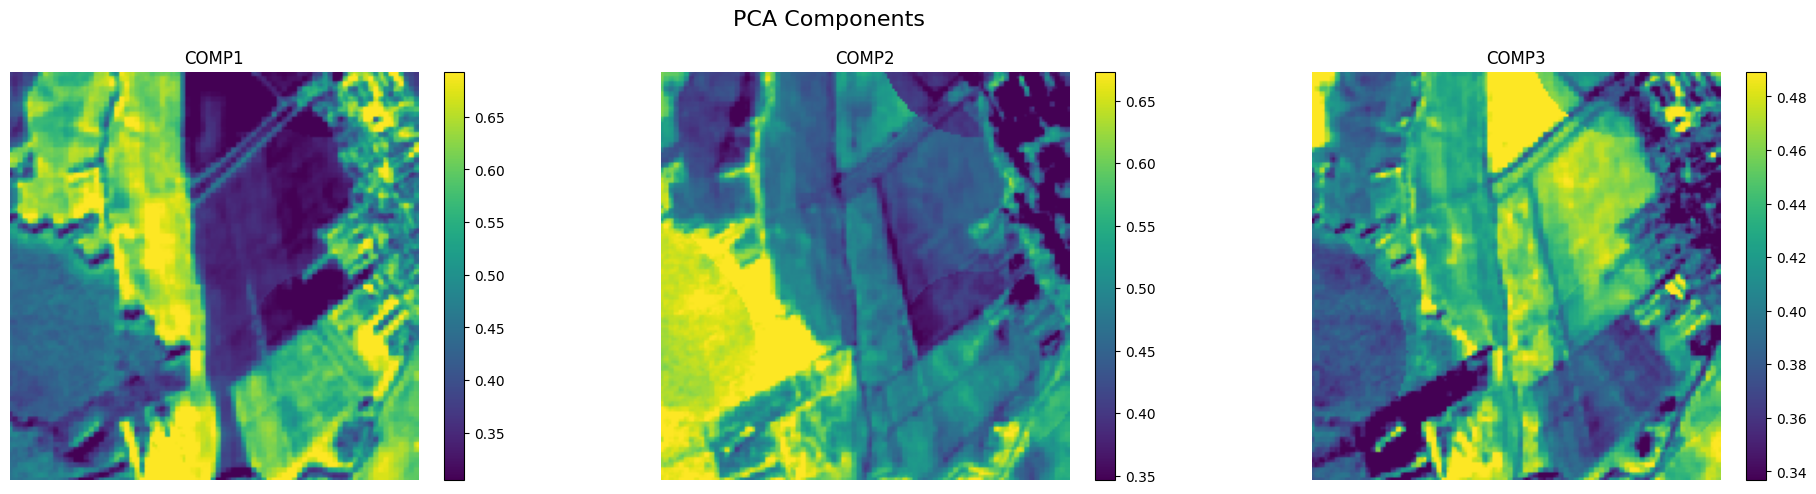

In [ ]:
pca_job_data_array= concat_features_to_bands_dim(pca_job_data)
plot_components(pca_job_data_array, "PCA")
